In [1]:
from brian2 import *

In [2]:
import matplotlib.pyplot as plt
%matplotlib notebook

# Intro to Brian2 Synapses

There are many types of synapses in Brian2, all highlighted in their tutorial (link: https://brian2.readthedocs.io/en/stable/resources/tutorials/2-intro-to-brian-synapses.html), but still I found the basic expressions for an alpha post-synaptic potential combined with a membrane time constant a bit tricky to follow. Here's an example of what I mean (link: https://brian2.readthedocs.io/en/stable/examples/frompapers.Diesmann_et_al_1999.html). The synapse rules here can be derived using this reference (link: https://brian2.readthedocs.io/en/stable/user/converting_from_integrated_form.html), but knowing why the external noise terms enter into the "y" variable in the Diesmann simulation always confused me. Below are notes to myself on how to think about these derviative expressions, step by step. 

# Integrate and Fire Neurons

Let's start with the basic idea for an integrate-and-fire neuron (link to ref: https://neuronaldynamics.epfl.ch/online/Ch1.S3.html). We imagine that there's a current entering the cell (due to synaptic activity or an experimentalist injecting current), and that current will cause a deflection in the cell membrane voltage. What's a good model for what happens here? The neuron is surrounded by a cell membrane, which is a  good insulator, meaning it can build up charge. However, it will not be able to hold that charge forever. The membrane will slowly "leak" the charge. The membrane can thus be modeled with a capacitor $C$ in parallel with a resistor $R$ driven by a current $I(t)$. The "leakiness" of the membrane is dictated by $R$ (low $R$ = leaky membrane) and $C$ (low $C$ = little charge can be held by the membrane). Formally: 

$I(t) = I_r(t) + I_c(t) $

$ I(t) = \frac{V(t)-V_{rest}}{R} + C \frac{dV}{dt}$ 

Let $\tau_m = RC$: 

$ I(t) R = V(t)-V_{rest} + \tau_m \frac{dV}{dt} $

$ \tau_m \frac{dV}{dt} = -(V(t)-V_{rest}) + I(t) R$   



# Post Synpatic Potentials -- not voltage dependent, alpha function

The $I(t) R$ term catches all types of inputs. If inputs are directly input currents, they can replace the $I(t)$ part of the expression. Alternatively, if they are input potentials (e.g. post-synaptic potentials) they can replace the full term. Let's consider a single neuron with excitatory post synaptic potentials due to many pre-synaptic neurons. While there are many very detailed expressions for post-synaptic potentials depending on the desired neurotransmitter to be modeled (e.g. AMPA vs. GABA), a common expression for simple models is an alpha synapse: 

$PSP(t) = \sum_i^{N} w_i \sum_{t_i} \frac{t}{\tau_p} e^{-\frac{t}{\tau_p}}$

In words, this PSP expression sums over all presynaptic neurons ($i=1:N$) and over all spikes from that particular presynaptic neuron ($t_i$). Each spike causes a slight increase in potential with a rise time (peak value reached at $t=\tau_p$) and a decay following the peak. Each presynaptic neuron has its own weight $w_i$. 

Now imagine we wanted to insert the $PSP$ expression into the IAF neuron expression: 

$ \tau_m \frac{dV}{dt} = -(V(t)-V_{rest}) + I(t) R$

$ \tau_m \frac{dV}{dt} = -(V(t)-V_{rest}) + PSP(t)$

The final step is now how to write these expressions out so that Brian2 can understand what we want to do. See the Brian2 tutorials for starters on the syntax of creating networks. Here we'll focus on how to write these expressions as differential equations (see this for a start:  https://brian2.readthedocs.io/en/stable/user/converting_from_integrated_form.html) 

# Write out PSP expressions in differential form

For now lets simplify $PSP(t)$ such that we're only summing over a single pre-synaptic neuron, and assume that there's only one spike falling at $t=0$: 

$ \tau_m \frac{dV}{dt} = -(V(t)-V_{rest}) + PSP(t)$


$PSP(t) = w \frac{t}{\tau_p} e^{-\frac{t}{\tau_p}}$

We follow the guidance here (https://brian2.readthedocs.io/en/stable/user/converting_from_integrated_form.html) to define a new variable $s = \frac{t}{\tau_p}$: 

$PSP = w s e^{-s}$

This is now easier to differentiate: 

$\frac{dPSP}{ds} = w e^{-s} - w se^{-s}$

$ \frac{dPSP}{ds} = w e^{-s} - PSP $



Now let variable $g = w e^{-s}$: 

$ \frac{dPSP}{ds} = g - PSP $

Ok but now this expression is in the form of $ \frac{dPSP}{ds}$ not $ \frac{dPSP}{dt}$: 

$ \frac{dPSP}{dt} = \frac{dPSP}{ds} \frac{ds}{dt} = (g - PSP)*(\frac{1}{\tau_p})$

Ok so now our diff eqns are: 

1. $ \tau_m \frac{dV}{dt} = -(V(t)-V_{rest}) + PSP(t)$


2. $ \frac{dPSP}{dt} = (g - PSP)*(\frac{1}{\tau_p}) $


But now Brian2 has no idea what the dynamics of "g" are so we can write: 
    
$\frac{dG}{dt} = \frac{dg}{ds} \frac{ds}{dt} = - w e^{-s} \frac{1}{\tau_p} = - g \frac{1}{\tau_p}$

Ok so now our diff eqns are: 

1. $\frac{dV}{dt} = (-(V(t)-V_{rest}) + PSP(t)) \frac{1}{\tau_m} $


2. $ \frac{dPSP}{dt} = (g - PSP)(\frac{1}{\tau_p}) $


3. $\frac{dG}{dt} = - g \frac{1}{\tau_p}$


In summary, expression 1 describes the membrane dynamics of the cell (leakiness/intergration) of incoming PSPs. Expressions 2 and 3 describe the dynamics of the post synaptic potential

Finally, there's the way that Brian2 deals with incoming spikes. We kept the $w$ in the expression used to define $g(t)$ to make it easier to follow how to add a presynaptic neuron specific weight. Note that if we want to tell Brian2 that a presynaptic spike happened we just need to increment $g$ by $w$: $g = g + w$. Let's see how this works: 

$\frac{dG}{dt} = -g \frac{1}{\tau_p}$

$g(t) = \int - \frac{g}{\tau_p}$ with the inital condition that $ g(0) = w $

Then the solution to $g(t)$ is: $g(t) = w e^{-\frac{t}{\tau_p}}$

This expression for $g(t)$ matches the one we see defined above. In other words, if we increment g by w, the dynamics of ($\frac{dG}{dt}$) define a process that matches what we initally intended ($PSP(t) = w (\frac{t}{\tau_p} e^{- \frac{t}{\tau_p}} )$ ).

Below we simulate the effect of a single presynaptic spike on the membrane voltage ($V_m$). We also explicitly track the PSP, the "g" variable, and the PSP we expect given the expression $PSP(t) = we^{-\frac{t}{\tau_p}}$ with a rise time of 1.7ms and a peak weight of 0.14mV; 

<IPython.core.display.Javascript object>


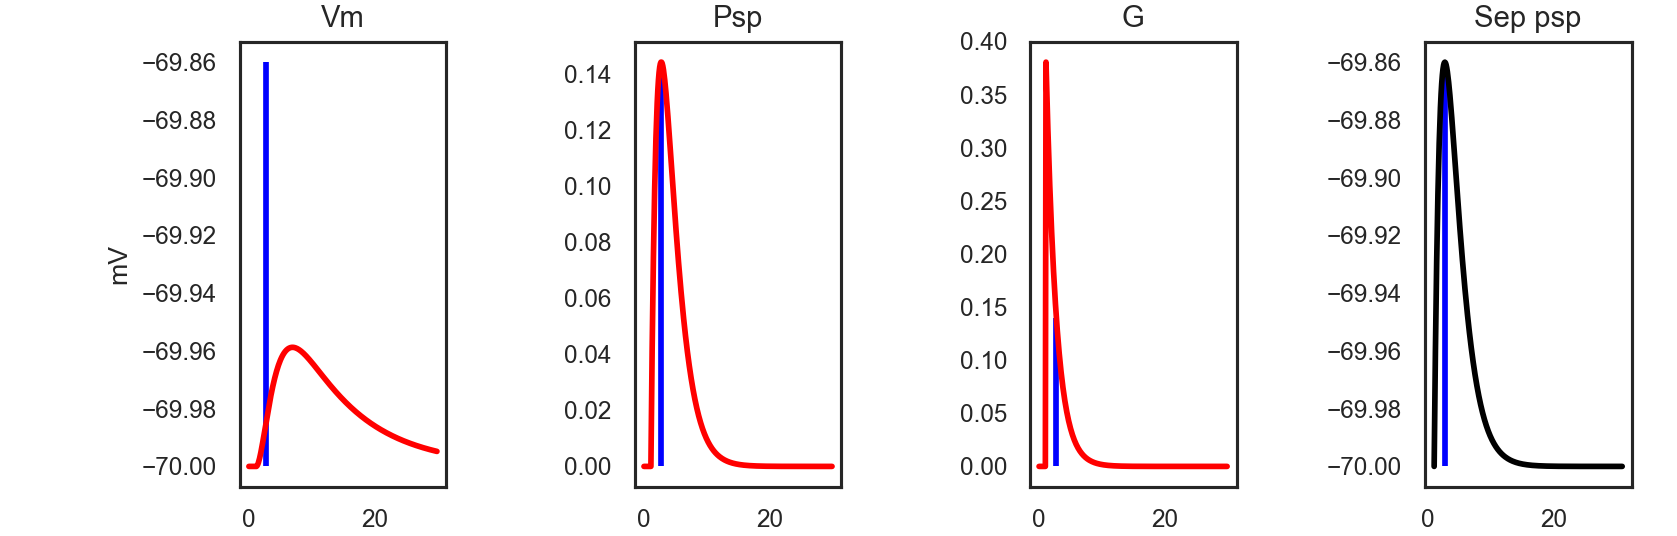

In [18]:
simulate_synapse()

In [5]:
def PSP(alpha_tau=1.7, wt = 0.14):
    t = np.arange(300)/10.
    w_ = wt*np.exp(1)
    PSP = w_*t/alpha_tau*np.exp(-1*t/alpha_tau)
    return t, PSP

In [13]:
def exp(alpha_tau=1., wt = 0.14):
    t = np.arange(300)/10.
    PSP = wt*np.exp(-1*t/alpha_tau)
    return t, PSP


## Plot different synapse dynamics options -- alpha vs. exp

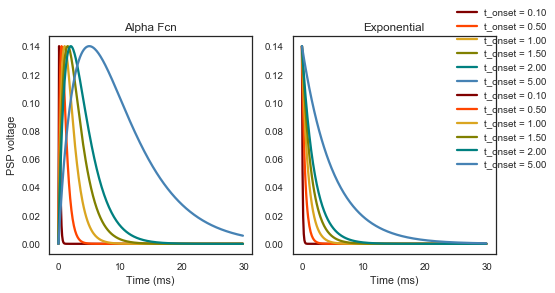

In [18]:
f, ax = plt.subplots(ncols = 2, figsize=(8, 4))
cols = ['maroon', 'orangered', 'goldenrod','olive','teal','steelblue']
for it, t in enumerate([0.1, .5, 1., 1.5, 2.0, 5.]):
    tx,psp = PSP(alpha_tau=t)
    ax[0].plot(tx, psp, '-', color=cols[it], label='t_onset = %.2f'%t)
    
    tx,psp = exp(alpha_tau=t)
    ax[1].plot(tx, psp, '-', color=cols[it], label='t_onset = %.2f'%t)
    
ax[0].set_ylabel('PSP voltage')
ax[0].set_xlabel('Time (ms)')
ax[0].set_title('Alpha Fcn')

ax[1].set_xlabel('Time (ms)')
ax[1].set_title('Exponential')

f.legend()

In [2]:
def simulate_synapse(membrane_ts=10, alpha_ts = 1.7, wt = .14, seed_num = None):
    
    #### Clear memory ###
    start_scope()
    
    ### Background drive 
    drive = 0*mV/ms;
    
    ### Noise added to background drive 
    noise = 0
    
    ### Synaptic delay 
    delayi = 0
        
    # Neuron model parameters
    Vr = -70*mV ## Resting potential; 
    Vt = -55*mV ## spiking threshold; 

    ### Membrane time constant -- how well does this postsynaptic neuron integrate ? ##
    taum = membrane_ts*ms

    #post synaptic potential; 
    taupsp = alpha_ts*ms 

    ### Effect of pre-synaptic spike on postsynaptic 
    w_ = wt*np.exp(1)
    weight = w_*mV # for 1.7 ms, 0.14mv peak PSP 

    ########## Equations #########
    eqs = Equations('''
    dV/dt = (-(V-Vr) + p)*(1./taum) : volt
    dp/dt = (-p+g)*(1./taupsp) : volt
    dg/dt = -g*(1./taupsp) + drive + (noise*1*mV/ms**0.5)*xi: volt
    ''')

    P = NeuronGroup(N=1, model=eqs,
                    threshold='V>Vt', reset='V=Vr', refractory=1*ms,
                    method='euler')

    ### Large input generator 
    input_n = 1 ### how many input spikes 
    tms = np.array([1])*ms
    tms_ix = np.arange(input_n)
    
    Pinput = SpikeGeneratorGroup(len(tms), tms_ix, tms)
    Sinput = Synapses(Pinput, P, on_pre='g+=weight')
    Sinput.connect(p=1.0)
    
    # Record the spikes
    M = StateMonitor(P, 'V', record=True) 
    Mp = StateMonitor(P, 'p', record=True)
    Mg = StateMonitor(P, 'g', record=True)
    
    Mgp = SpikeMonitor(P)
    Minput = SpikeMonitor(Pinput)
    
    # Setup the network, and run it
    P.V = 'Vr'

    # Set the seed for better reproducibility (?)
    if seed_num is None:
        pass
    else:
        seed(seed_num)

    # Run the full model;
    duration = 30*ms
    run(duration)

    # Return the spike times and identitie
    f, ax = plt.subplots(ncols = 4)
    ax[0].vlines(1 + alpha_ts, Vr/mV, Vr/mV+(wt), 'b')
    ax[0].plot(np.arange(300)/10., M.V[0, :]/mV, 'r-')
    ax[0].set_ylabel('mV')
    
    ax[1].vlines(1 + alpha_ts, 0, (wt), 'b')
    ax[1].plot(np.arange(300)/10., Mp.p[0, :]/mV, 'r-')
    
    ax[2].vlines(1 + alpha_ts, 0, (wt), 'b')
    ax[2].plot(np.arange(300)/10., Mg.g[0, :]/mV, 'r-')
    
    tpsp,psp = PSP(alpha_tau=alpha_ts, wt=wt)
    ax[3].plot(tpsp+1, psp+Vr/mV, 'k-', label='Sim')
    ax[3].vlines(1 + alpha_ts, Vr/mV, Vr/mV+(wt), 'b')
    
    nms = ['Vm', 'Psp', 'G', 'Sep psp']
    for ia, axi in enumerate(ax):
        axi.set_title(nms[ia])
    f.tight_layout()
        

# Conductance based synapses #

Many synaptic expressions are not written as post synaptic potentials, but rather as input currents associated either with ion channels (e.g. as in Hodgkin-Huxley model), or with a specific type of neurotransmitter (e.g. https://neuronaldynamics.epfl.ch/online/Ch3.S1.html). These expressions will often look like this: 

$ I_{trans} = g_{trans} (V^{trans} - V(t)) $ 

where $I$ refers to the input current, $g$ is the conductance (reciprocal of resistance), and $V^{trans}$ is the reversal potential of the ion or neurotransmitter induced current. The term "reversal potential" makes sense for ion-channel. Recall that the membrane separates intracellular and extracellular fluids that have differing ionic concentrations of Na, K, and other ions. Differences in ion concentrations result in expected potential differences called the "nearst potential" (see https://neuronaldynamics.epfl.ch/online/Ch2.S1.html). Since the system wants to be in equillibrium, if the true potential varies from the nearst potential, ions will flow to move the membrane voltage closer to that potential. The further from the nearst potential, the stronger the current is, hence $I$ being dependent on $V^{ion} - V$. 

In the case of neurotransmitters, a similar expression has been adopted to reflect the influence of neurotransmitters on specific ion channels; 

To model excitatory and inhibitory transmitters, we can write: 

$I_{syn} = \sum_{k} I_k $ for $k \in I, E$

$I_{syn} = I_{E} + I_{I}$

$I_{syn} = g_{E}(t)*(V^{E} - V(t)) + g_{I}(t)*(V^{I} - V(t)) $

Finally, in this expression we can write: 
$ \tau_m \frac{dV}{dt} = -(V(t)-V_{rest}) + I(t) R$

$ \tau_m \frac{dV}{dt} = -(V(t)-V_{rest}) + I_{syn} / g_L $ where $g_L$ is the leak conductance of the neuron


# Write out PSP expressions in differential form